# Token Neighborhood Analysis

**Goal:** Examine the local neighborhood around semantically meaningful tokens to test the linear representation hypothesis.

**Target tokens:**
1. **'planet'** (token 50074) — Astronomical concept with rich semantic field
2. **'four'** (token 34024) — Abstract number concept
3. **'big'** (token 16154) — Scalar adjective

**Hypotheses to test:**
1. **Linear representation:** Do semantically related words lie along the same ray at different radii?
2. **Causal vs cosine:** What's the overlap between causal proximity and angular similarity?
3. **Radial meaning:** Does radius correlate with frequency, specificity, or abstraction level?

**Method:**
- **Causal neighborhood:** Find all tokens within radius R (hypersphere)
- **Cosine neighborhood:** Find tokens with cosine similarity > threshold (angular cone)
- **Decode and analyze:** What do the neighbors actually say?

**Inputs:**
- `distances_causal_32000_full.npy` — Full distance matrix
- `distances_causal_32000.pt` — Token indices and metadata
- Model embeddings — For cosine similarity computation

## Configuration

In [29]:
# Model
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

# Data paths
DISTANCES_PATH = '../data/vectors/distances_causal_32000_full.npy'
METADATA_PATH = '../data/vectors/distances_causal_32000.pt'
METRIC_TENSOR_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'

# Target tokens (from 07.56)
TARGETS = {
    'planet': 50074,
    'four': 34024,
    'big': 16154,
}

# Analysis parameters
CAUSAL_RADIUS = 70.0  # logometers (will explore different radii)
COSINE_THRESHOLD = 0.400  # Minimum cosine similarity for angular neighborhood
TOP_N = 50  # Maximum neighbors to decode and display

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Distances: {DISTANCES_PATH}")
print(f"  Causal radius: {CAUSAL_RADIUS} logometers")
print(f"  Cosine threshold: {COSINE_THRESHOLD}")
print(f"  Target tokens: {list(TARGETS.keys())}")

Configuration:
  Model: Qwen/Qwen3-4B-Instruct-2507
  Distances: ../data/vectors/distances_causal_32000_full.npy
  Causal radius: 70.0 logometers
  Cosine threshold: 0.4
  Target tokens: ['planet', 'four', 'big']


## Setup

In [30]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from collections import defaultdict

print("✓ Imports complete")

✓ Imports complete


## Load Distance Matrix and Metadata

In [31]:
print(f"Loading distance matrix from {DISTANCES_PATH}...")
distances = np.load(DISTANCES_PATH)

print(f"\nLoading metadata from {METADATA_PATH}...")
metadata = torch.load(METADATA_PATH, weights_only=False)
token_indices = metadata['token_indices'].numpy()

N = len(token_indices)

print(f"\n✓ Data loaded")
print(f"  N tokens: {N:,}")
print(f"  Distance matrix shape: {distances.shape}")
print(f"  Memory: {distances.nbytes / 1e9:.2f} GB")

# Create mapping: token_id → index in our sample
token_to_idx = {tid: idx for idx, tid in enumerate(token_indices)}
print(f"  Created token_id → sample_index mapping")

Loading distance matrix from ../data/vectors/distances_causal_32000_full.npy...

Loading metadata from ../data/vectors/distances_causal_32000.pt...

✓ Data loaded
  N tokens: 32,000
  Distance matrix shape: (32000, 32000)
  Memory: 4.10 GB
  Created token_id → sample_index mapping


## Load Model and Tokenizer

We need the unembedding matrix to compute cosine similarities.

In [32]:
print(f"Loading tokenizer from {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"\nLoading model (for unembedding matrix)...")
print("  This will take a minute...")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map='cpu',  # Keep on CPU to avoid memory issues
)

# Extract unembedding matrix (lm_head)
gamma = model.lm_head.weight.data.to(torch.float32).cpu()  # [vocab_size, hidden_dim]

print(f"\n✓ Model loaded")
print(f"  Vocab size: {tokenizer.vocab_size:,}")
print(f"  Unembedding matrix shape: {gamma.shape}")
print(f"  Memory: {gamma.element_size() * gamma.nelement() / 1e9:.2f} GB")

Loading tokenizer from Qwen/Qwen3-4B-Instruct-2507...

Loading model (for unembedding matrix)...
  This will take a minute...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


✓ Model loaded
  Vocab size: 151,643
  Unembedding matrix shape: torch.Size([151936, 2560])
  Memory: 1.56 GB


## Extract Embeddings for Our Sample

Get the subset of γ corresponding to our 32k token sample.

In [33]:
print("Extracting embeddings for our 32k sample...")
sampled_embeddings = gamma[token_indices]  # [32000, hidden_dim]

print(f"\n✓ Extracted sample embeddings")
print(f"  Shape: {sampled_embeddings.shape}")
print(f"  Memory: {sampled_embeddings.element_size() * sampled_embeddings.nelement() / 1e6:.2f} MB")

Extracting embeddings for our 32k sample...

✓ Extracted sample embeddings
  Shape: torch.Size([32000, 2560])
  Memory: 327.68 MB


## Compute Causal Norms

We'll need these for visualization and analysis.

In [34]:
print(f"Loading causal metric tensor from {METRIC_TENSOR_PATH}...")
metric_data = torch.load(METRIC_TENSOR_PATH, weights_only=False)
M = metric_data['M'].to(torch.float32).cpu()  # [hidden_dim, hidden_dim]

print(f"\nComputing causal norms for all tokens...")
# ||v||_M = sqrt(v^T M v)
causal_norms = torch.sqrt(torch.sum(sampled_embeddings @ M * sampled_embeddings, dim=1)).numpy()

print(f"\n✓ Causal norms computed")
print(f"  Shape: {causal_norms.shape}")
print(f"  Range: [{causal_norms.min():.2f}, {causal_norms.max():.2f}] logometers")
print(f"  Mean: {causal_norms.mean():.2f} logometers")
print(f"  Median: {np.median(causal_norms):.2f} logometers")

Loading causal metric tensor from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...

Computing causal norms for all tokens...

✓ Causal norms computed
  Shape: (32000,)
  Range: [21.45, 75.08] logometers
  Mean: 54.12 logometers
  Median: 55.26 logometers


## Analysis Function

Define a function to analyze a single token's neighborhood.

In [35]:
def analyze_token_neighborhood(token_name, token_id, causal_radius, cosine_threshold, top_n=50):
    """
    Analyze the neighborhood around a specific token.
    
    Returns:
        dict with 'causal_neighbors', 'cosine_neighbors', 'overlap', etc.
    """
    
    # Check if token is in our sample
    if token_id not in token_to_idx:
        print(f"\n❌ Token {token_id} ('{token_name}') not in our 32k sample!")
        return None
    
    idx = token_to_idx[token_id]
    
    print(f"\n{'=' * 80}")
    print(f"ANALYZING: '{token_name}' (token {token_id}, sample index {idx})")
    print(f"{'=' * 80}")
    
    # Get token's embedding and norm
    token_embedding = sampled_embeddings[idx]
    token_norm = causal_norms[idx]
    token_euclidean_norm = torch.norm(token_embedding).item()
    
    print(f"\nToken properties:")
    print(f"  Causal norm: {token_norm:.2f} logometers")
    print(f"  Euclidean norm: {token_euclidean_norm:.2f}")
    
    # ===== CAUSAL NEIGHBORHOOD =====
    print(f"\n{'-' * 80}")
    print(f"CAUSAL NEIGHBORHOOD (radius ≤ {causal_radius} logometers)")
    print(f"{'-' * 80}")
    
    causal_distances = distances[idx]
    causal_mask = (causal_distances > 0) & (causal_distances <= causal_radius)
    causal_neighbor_indices = np.where(causal_mask)[0]
    
    print(f"\nFound {len(causal_neighbor_indices)} neighbors within {causal_radius} logometers")
    
    if len(causal_neighbor_indices) > 0:
        # Sort by distance
        sorted_indices = causal_neighbor_indices[np.argsort(causal_distances[causal_neighbor_indices])]
        
        # Limit to top_n
        display_indices = sorted_indices[:top_n]
        
        print(f"\nTop {len(display_indices)} nearest causal neighbors:")
        print(f"{'Rank':<6} {'Distance':<12} {'Norm':<12} {'Token ID':<10} {'Text':<30}")
        print("-" * 80)
        
        causal_neighbor_ids = set()
        for rank, idx_neighbor in enumerate(display_indices, 1):
            dist = causal_distances[idx_neighbor]
            norm = causal_norms[idx_neighbor]
            tid = token_indices[idx_neighbor]
            text = tokenizer.decode([tid])
            
            causal_neighbor_ids.add(tid)
            print(f"{rank:<6} {dist:<12.4f} {norm:<12.2f} {tid:<10} {text:<30}")
    else:
        causal_neighbor_ids = set()
        print(f"\n⚠️  No neighbors found within {causal_radius} logometers")
    
    # ===== CAUSAL COSINE NEIGHBORHOOD =====
    print(f"\n{'-' * 80}")
    print(f"CAUSAL COSINE NEIGHBORHOOD (similarity ≥ {cosine_threshold})")
    print(f"(Using causal metric for angle computation)")
    print(f"{'-' * 80}")
    
    # Compute CAUSAL cosine similarities: cos(θ_M) = (u^T M v) / (||u||_M · ||v||_M)
    causal_dot_products = (sampled_embeddings @ M @ token_embedding)  # u^T M v
    causal_norm_target = torch.tensor(token_norm)  # ||target||_M (already computed)
    causal_norms_all = torch.tensor(causal_norms)  # ||all||_M (already computed)
    
    cosine_sims = causal_dot_products / (causal_norms_all * causal_norm_target)
    
    # Filter by threshold (exclude self)
    cosine_mask = (cosine_sims >= cosine_threshold)
    cosine_mask[idx] = False  # Exclude the token itself
    cosine_neighbor_indices = torch.where(cosine_mask)[0].numpy()
    
    print(f"\nFound {len(cosine_neighbor_indices)} neighbors with causal cosine ≥ {cosine_threshold}")
    
    if len(cosine_neighbor_indices) > 0:
        # Sort by cosine similarity (descending)
        cosine_vals = cosine_sims[cosine_neighbor_indices].numpy()
        sorted_order = np.argsort(-cosine_vals)
        sorted_indices_cosine = cosine_neighbor_indices[sorted_order]
        
        # Limit to top_n
        display_indices_cosine = sorted_indices_cosine[:top_n]
        
        print(f"\nTop {len(display_indices_cosine)} nearest causal cosine neighbors:")
        print(f"{'Rank':<6} {'Causal Cos':<12} {'Causal Dist':<12} {'Norm':<12} {'Token ID':<10} {'Text':<30}")
        print("-" * 80)
        
        cosine_neighbor_ids = set()
        for rank, idx_neighbor in enumerate(display_indices_cosine, 1):
            cos_sim = cosine_sims[idx_neighbor].item()
            causal_dist = distances[idx, idx_neighbor]
            norm = causal_norms[idx_neighbor]
            tid = token_indices[idx_neighbor]
            text = tokenizer.decode([tid])
            
            cosine_neighbor_ids.add(tid)
            print(f"{rank:<6} {cos_sim:<12.4f} {causal_dist:<12.2f} {norm:<12.2f} {tid:<10} {text:<30}")
    else:
        cosine_neighbor_ids = set()
        print(f"\n⚠️  No neighbors found with causal cosine ≥ {cosine_threshold}")
    
    # ===== OVERLAP ANALYSIS =====
    print(f"\n{'-' * 80}")
    print(f"OVERLAP ANALYSIS")
    print(f"{'-' * 80}")
    
    overlap = causal_neighbor_ids & cosine_neighbor_ids
    causal_only = causal_neighbor_ids - cosine_neighbor_ids
    cosine_only = cosine_neighbor_ids - causal_neighbor_ids
    
    total_neighbors = len(causal_neighbor_ids | cosine_neighbor_ids)
    
    print(f"\nNeighborhood statistics:")
    print(f"  Causal neighbors: {len(causal_neighbor_ids)}")
    print(f"  Causal cosine neighbors: {len(cosine_neighbor_ids)}")
    print(f"  Overlap (both): {len(overlap)}")
    print(f"  Causal only: {len(causal_only)}")
    print(f"  Causal cosine only: {len(cosine_only)}")
    print(f"  Total unique neighbors: {total_neighbors}")
    
    if total_neighbors > 0:
        overlap_pct = 100 * len(overlap) / total_neighbors
        print(f"  Overlap percentage: {overlap_pct:.1f}%")
    
    if len(overlap) > 0:
        print(f"\nTokens in BOTH neighborhoods (causal distance AND causal cosine):")
        for tid in sorted(overlap):
            text = tokenizer.decode([tid])
            print(f"  • {tid}: '{text}'")
    
    return {
        'token_name': token_name,
        'token_id': token_id,
        'token_norm': token_norm,
        'causal_neighbor_ids': causal_neighbor_ids,
        'cosine_neighbor_ids': cosine_neighbor_ids,
        'overlap': overlap,
    }

print("✓ Analysis function defined")

✓ Analysis function defined


## Analysis 1: 'planet'

**Hypothesis:** Astronomical terms (sun, moon, star, earth) might cluster along the same ray or in causal proximity.

In [36]:
result_planet = analyze_token_neighborhood(
    token_name='planet',
    token_id=TARGETS['planet'],
    causal_radius=CAUSAL_RADIUS,
    cosine_threshold=COSINE_THRESHOLD,
    top_n=TOP_N
)


ANALYZING: 'planet' (token 50074, sample index 20043)

Token properties:
  Causal norm: 58.35 logometers
  Euclidean norm: 1.17

--------------------------------------------------------------------------------
CAUSAL NEIGHBORHOOD (radius ≤ 70.0 logometers)
--------------------------------------------------------------------------------

Found 4190 neighbors within 70.0 logometers

Top 50 nearest causal neighbors:
Rank   Distance     Norm         Token ID   Text                          
--------------------------------------------------------------------------------
1      43.5625      56.09        59634      Planet                        
2      54.6562      21.70        150853     겚                             
3      54.6875      21.60        149798     큉                             
4      54.6875      21.97        150308     쓻                             
5      54.6875      21.63        151036     쩻                             
6      54.7188      21.82        150877     냵      

## Analysis 2: 'four'

**Hypothesis:** Numbers might form a linear sequence in semantic space.

In [37]:
result_four = analyze_token_neighborhood(
    token_name='four',
    token_id=TARGETS['four'],
    causal_radius=CAUSAL_RADIUS,
    cosine_threshold=COSINE_THRESHOLD,
    top_n=TOP_N
)


ANALYZING: 'four' (token 34024, sample index 27606)

Token properties:
  Causal norm: 53.64 logometers
  Euclidean norm: 0.98

--------------------------------------------------------------------------------
CAUSAL NEIGHBORHOOD (radius ≤ 70.0 logometers)
--------------------------------------------------------------------------------

Found 11613 neighbors within 70.0 logometers

Top 50 nearest causal neighbors:
Rank   Distance     Norm         Token ID   Text                          
--------------------------------------------------------------------------------
1      35.3125      52.90        3040        four                         
2      49.4375      56.96        63703      四                             
3      49.8125      23.52        147114     ﭔ                             
4      49.9375      21.78        150320     핕                             
5      49.9688      22.05        150288     ﳥ                             
6      49.9688      21.71        142142     אוניב   

## Analysis 3: 'big'

**Hypothesis:** Scalar adjectives might show gradation along a ray.

In [38]:
result_big = analyze_token_neighborhood(
    token_name='big',
    token_id=TARGETS['big'],
    causal_radius=CAUSAL_RADIUS,
    cosine_threshold=COSINE_THRESHOLD,
    top_n=TOP_N
)


ANALYZING: 'big' (token 16154, sample index 22383)

Token properties:
  Causal norm: 57.06 logometers
  Euclidean norm: 1.09

--------------------------------------------------------------------------------
CAUSAL NEIGHBORHOOD (radius ≤ 70.0 logometers)
--------------------------------------------------------------------------------

Found 5667 neighbors within 70.0 logometers

Top 50 nearest causal neighbors:
Rank   Distance     Norm         Token ID   Text                          
--------------------------------------------------------------------------------
1      40.1250      55.54        15636      Big                           
2      43.0312      52.22        36386      _big                          
3      45.9688      53.87        36854       BIG                          
4      48.0312      56.96        69411      -big                          
5      53.2812      21.52        150905     딮                             
6      53.2812      21.83        57408      :---------

## Visualization: Causal Distance vs Cosine Similarity

For each target token, plot its neighbors in (causal_distance, cosine_similarity) space.

In [39]:
def plot_neighborhood(token_name, token_id, causal_radius, cosine_threshold, top_n=100):
    """
    Scatter plot: causal distance vs CAUSAL cosine similarity for all neighbors.
    """
    
    if token_id not in token_to_idx:
        print(f"Token {token_id} not in sample")
        return
    
    idx = token_to_idx[token_id]
    token_embedding = sampled_embeddings[idx]
    token_norm = causal_norms[idx]
    
    # Get causal distances
    causal_dists = distances[idx]
    
    # Compute CAUSAL cosine similarities
    causal_dot_products = (sampled_embeddings @ M @ token_embedding)
    causal_norm_target = torch.tensor(token_norm)
    causal_norms_all = torch.tensor(causal_norms)
    cosine_sims = (causal_dot_products / (causal_norms_all * causal_norm_target)).numpy()
    
    # Filter out self and very distant points
    mask = (np.arange(N) != idx) & (causal_dists < 100)  # Arbitrary cutoff for visualization
    
    causal_dists_filtered = causal_dists[mask]
    cosine_sims_filtered = cosine_sims[mask]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Scatter plot
    ax.scatter(causal_dists_filtered, cosine_sims_filtered, alpha=0.3, s=10, c='gray')
    
    # Highlight regions
    ax.axvline(x=causal_radius, color='red', linestyle='--', linewidth=2, 
               label=f'Causal radius = {causal_radius}')
    ax.axhline(y=cosine_threshold, color='blue', linestyle='--', linewidth=2,
               label=f'Causal cosine threshold = {cosine_threshold}')
    
    # Mark quadrants
    ax.text(causal_radius/2, cosine_threshold + 0.01, 'BOTH', 
            fontsize=12, fontweight='bold', color='green', ha='center')
    ax.text(causal_radius/2, cosine_threshold - 0.01, 'Causal only',
            fontsize=10, color='red', ha='center', va='top')
    ax.text(causal_radius*3, cosine_threshold + 0.01, 'Cosine only',
            fontsize=10, color='blue', ha='center')
    
    ax.set_xlabel('Causal Distance (logometers)', fontsize=12)
    ax.set_ylabel('Causal Cosine Similarity', fontsize=12)
    ax.set_title(f"Neighborhood Structure: '{token_name}' (token {token_id})\n(Using causal metric for both distance and angle)", 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined")

✓ Visualization function defined


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_58854/1272619802.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


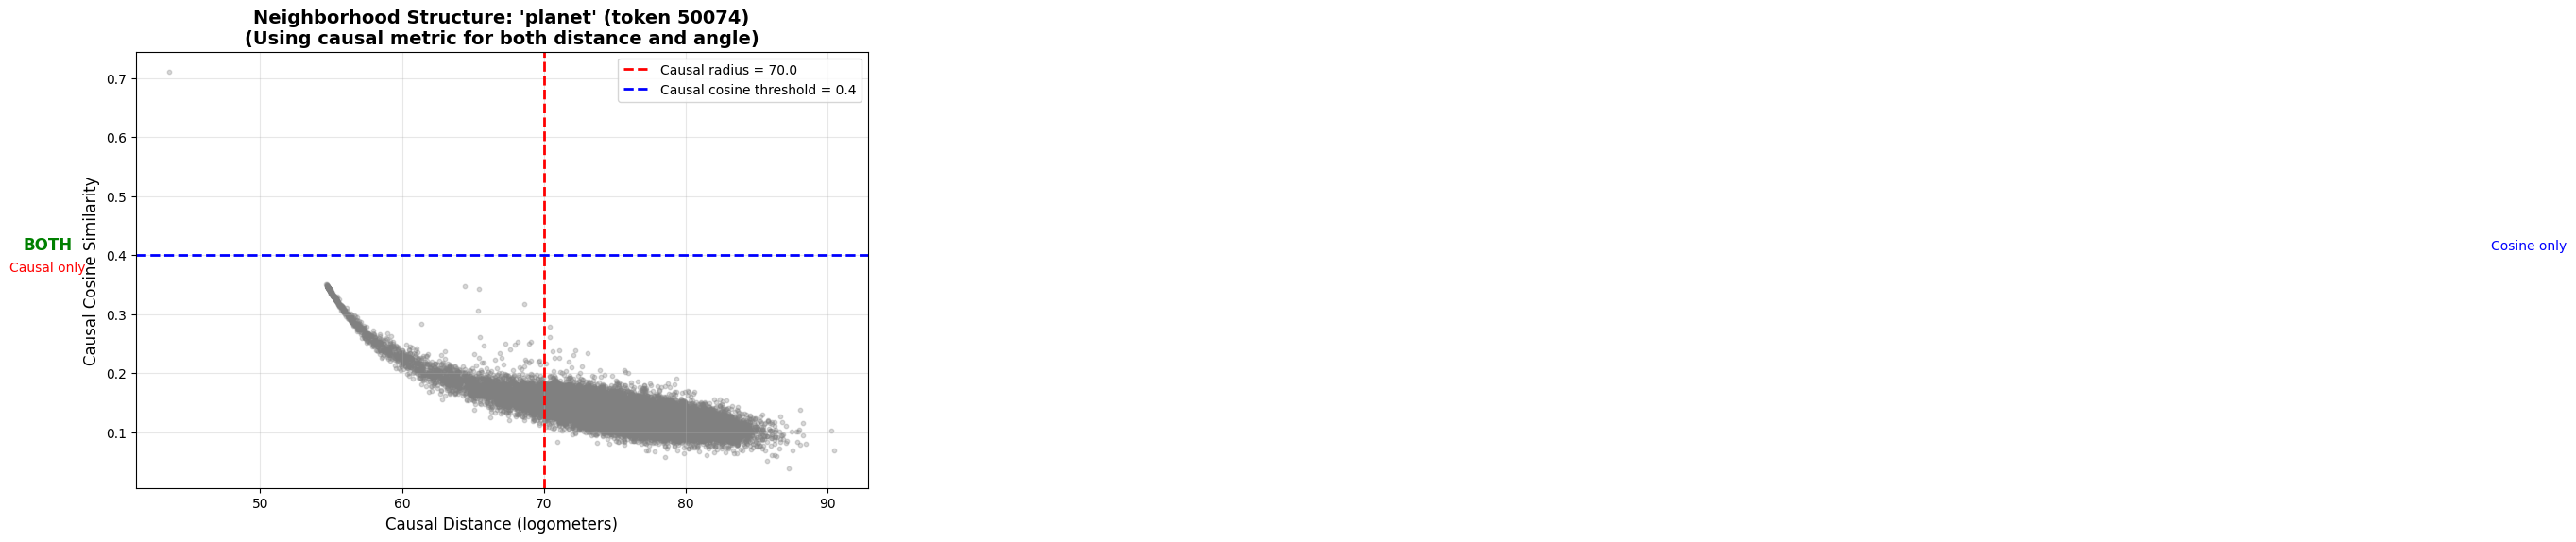

In [40]:
# Plot for 'planet'
plot_neighborhood('planet', TARGETS['planet'], CAUSAL_RADIUS, COSINE_THRESHOLD)

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_58854/1272619802.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


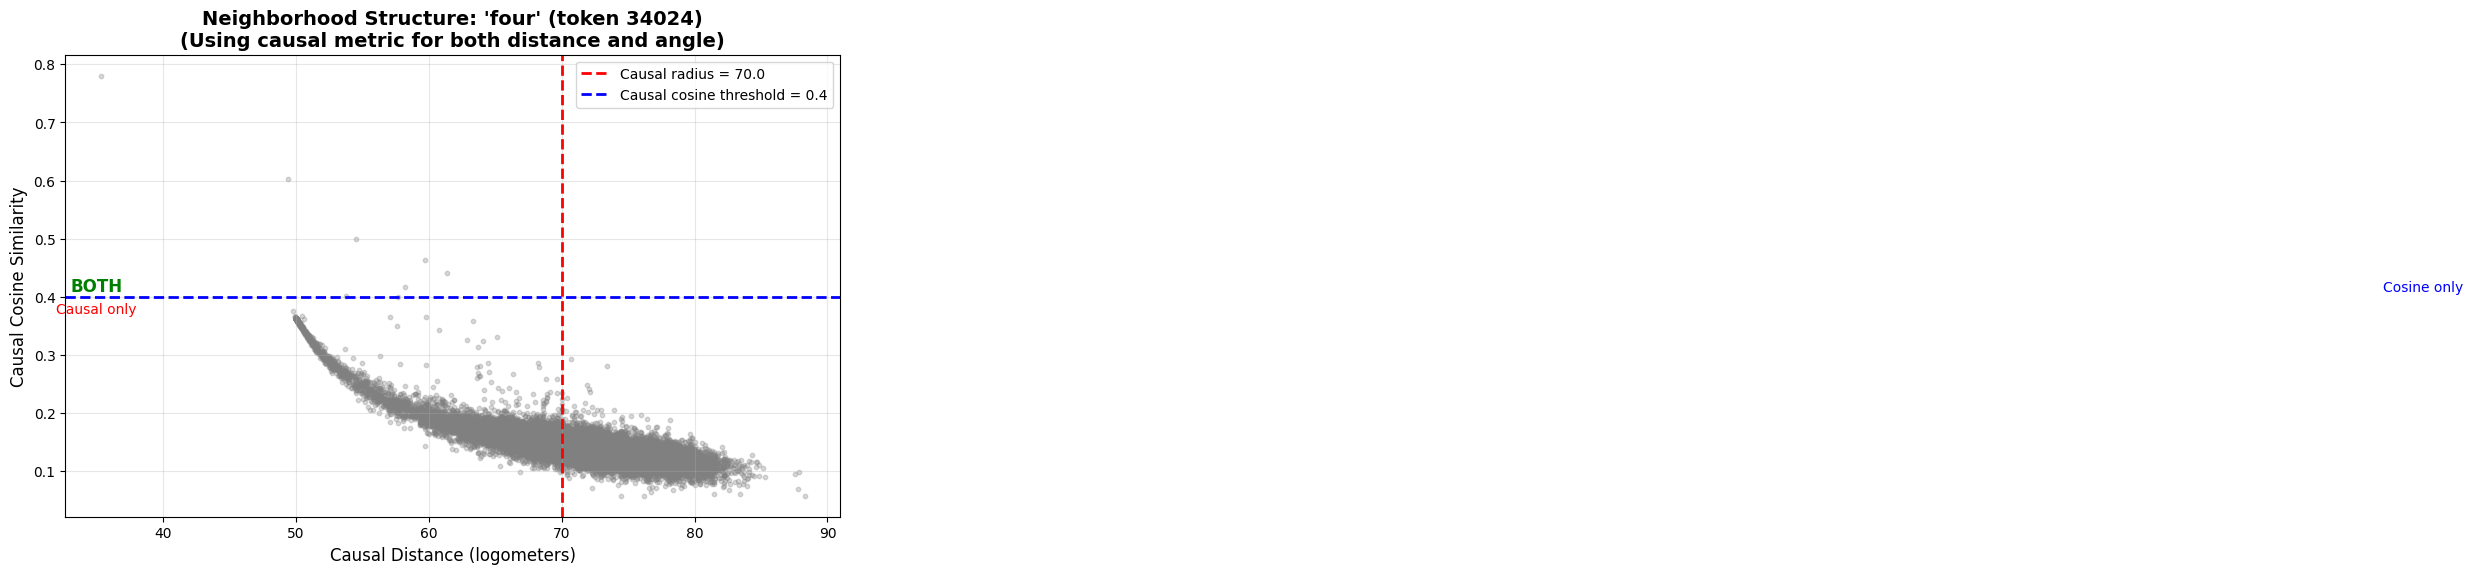

In [41]:
# Plot for 'four'
plot_neighborhood('four', TARGETS['four'], CAUSAL_RADIUS, COSINE_THRESHOLD)

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_58854/1272619802.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


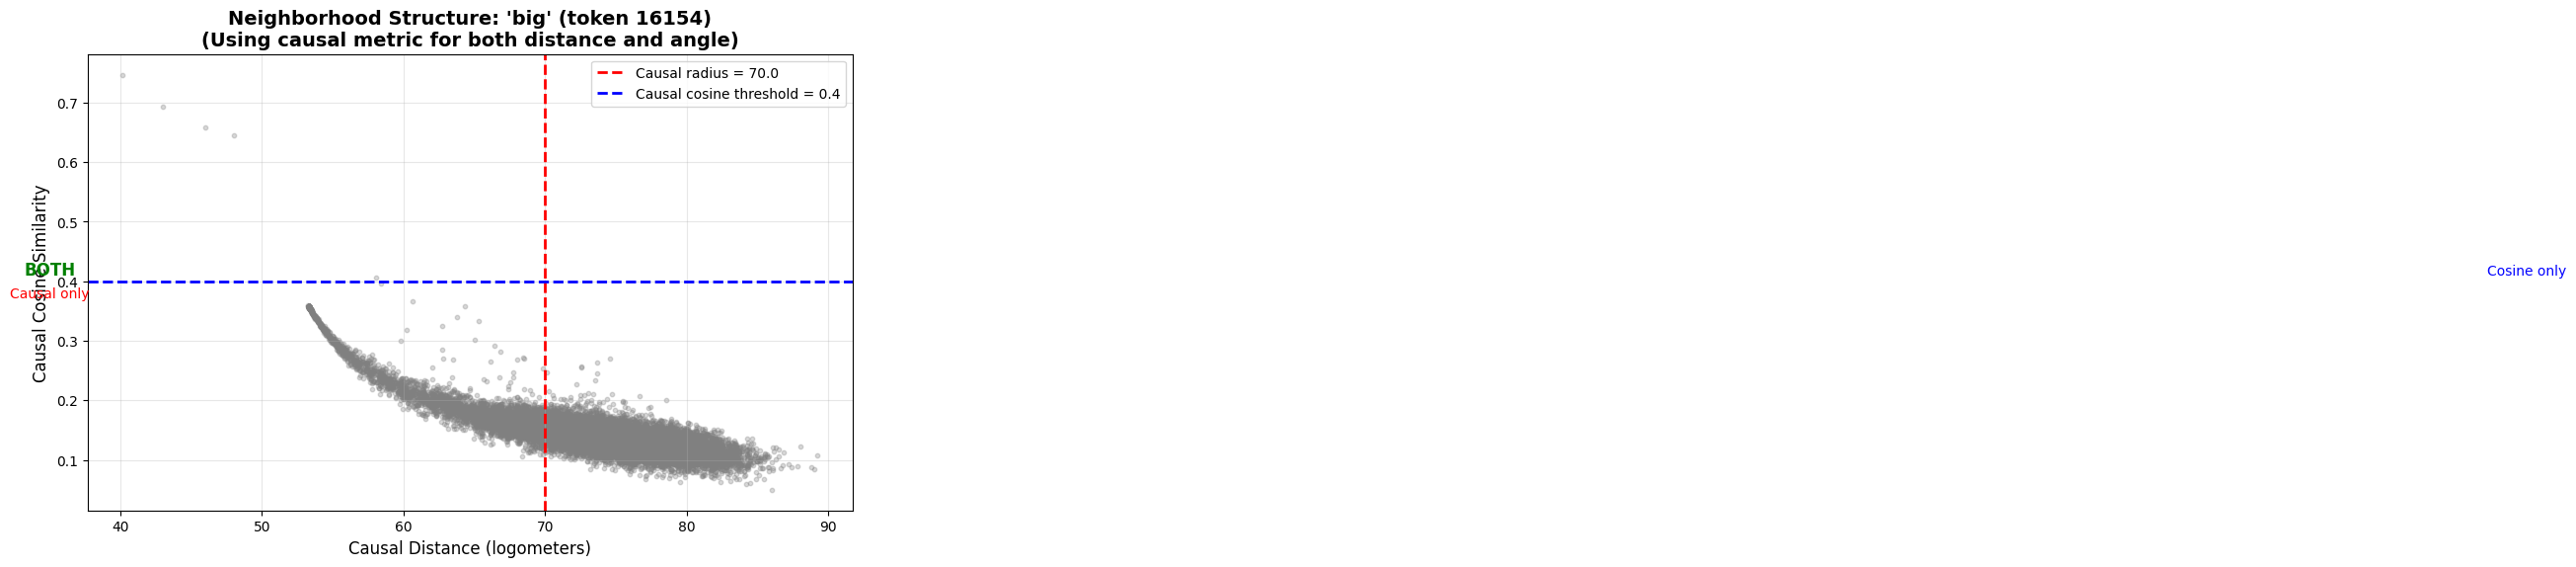

In [42]:
# Plot for 'big'
plot_neighborhood('big', TARGETS['big'], CAUSAL_RADIUS, COSINE_THRESHOLD)

## Summary and Interpretation

**Key questions:**

1. **Linear representation hypothesis:** Do semantically related words appear in the same neighborhoods?
   - Check if 'planet' has neighbors like 'star', 'moon', 'sun', 'earth'
   - Check if 'four' has neighbors like other numbers or counting-related terms
   - Check if 'big' has neighbors related to size

2. **Causal vs cosine overlap:** What percentage of neighbors are in both neighborhoods?
   - High overlap → causal and cosine metrics agree (radial structure not dominant)
   - Low overlap → causal metric captures radial stratification that cosine misses

3. **Radial patterns:** Do cosine-similar tokens have similar or different causal norms?
   - If cosine neighbors span a wide range of norms → radial stratification exists
   - If cosine neighbors cluster at similar norms → less radial structure

4. **Domain differences:** Do different semantic domains show different geometric patterns?
   - Concrete (planet) vs abstract (big) vs symbolic (four)
   - Does topology vary by semantic category?